In [ ]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm

In [ ]:
dist = torch.distributions.Beta(3, 5)

In [ ]:
dist.mean

In [ ]:
from run.run import run
from users.user import User
from assistants.ai_assistant import AiAssistant

In [ ]:
decision_rule_kwargs = dict(
    decision_rule='epsilon_rule',
    decision_rule_parameters=dict(
        epsilon=0.1)
)

run_name = f"{decision_rule_kwargs['decision_rule']}"

trace = run(
    user_model=User,
    user_goal=[0.4, 0.8],
    assistant_model=AiAssistant,
    seed=1,
    user_parameters=(8.0, 0.5),
    inference_learning_rate=1e-6,
    n_step=200,
    **decision_rule_kwargs)

In [ ]:
# Extract data
user_goal = trace["user_goal"]
belief_trace = np.asarray(trace["assistant_belief"])
user_action_trace = np.asarray(trace["user_action"])
assistant_action_trace = np.asarray(trace["assistant_action"]).T
n_epochs = len(user_action_trace)
n_targets = len(user_goal)

In [ ]:
belief_trace.shape

In [ ]:
# Create figure
fig, axes = plt.subplots(
    nrows=n_targets+1, figsize=(15, 8),
    constrained_layout=True)

for target in range(n_targets):
    ax = axes[target]
    
    x = torch.linspace(0., 1., 100)
    
    belief = []
    
    for epoch in range(n_epochs):
        log_c0, log_c1 = belief_trace[epoch, target, :]
        c0, c1 = np.exp(log_c0), np.exp(log_c1)
        belief_epoch = torch.distributions.Beta(concentration0=3.0, concentration1=1.0).log_prob(x).exp().numpy()
        belief.append(belief_epoch)
        
    x_min, x_max = 0, n_epochs
    y_min, y_max = 1.0, 0.0 # Note the inversion
    im = ax.imshow(
        np.transpose(belief),
        extent = [x_min , x_max, y_min , y_max],
        interpolation="nearest",
        aspect="auto",
        cmap="viridis",
        # vmin=0, vmax=1,
    )

#     epochs = np.arange(n_epochs)

#     a = np.asarray(user_action_trace)
#     idx = a == 0
#     ax.scatter(epochs[idx], assistant_action_trace[idx], c="none", marker='^', edgecolor="C1")
#     idx = a == 1
#     ax.scatter(epochs[idx], assistant_action_trace[idx], c='red', marker='v')

    ax.axhline(user_goal[target], ls="--", color="red")

    ax.invert_yaxis()
    ax.yaxis.get_major_locator().set_params(integer=True)

    ax.set_xlim([0, n_epochs])

    ax.set_xlabel("Time")
    ax.set_ylabel("Target")

    cb = fig.colorbar(im, ax=ax)
    cb.set_label("Assistant belief")

ax = axes[-1]
for i, x in enumerate(assistant_action_trace):
    ax.plot(x, label=f"Target {i}", lw=1)

ax.set_xlabel("Time")
ax.set_ylabel("Position")

ax.set_xlim([0, n_epochs])

ax.legend();

In [ ]:
x = torch.linspace(0., 1., 100)
plt.plot(x.numpy(), torch.distributions.Beta(concentration0=3.0, concentration1=1.0).log_prob(x).exp().numpy())

In [ ]:
x = torch.linspace(0., 1., 100)
plt.plot(x.numpy(), 1 / (1 + torch.exp(50*(0.2 - x))))

In [ ]:
def p_user_complains(distance):
    
    return 1 / (1 + torch.exp(50*(0.2 - distance)))

In [ ]:
def free_energy_belief(b_prime, y, a, b, n_sample=100):
    r"""
    KL divergence between variational density (:math:`Q(\mathbf{Z})`)
    and generative density (:math:`P(\mathbf{X}, \mathbf{Z})`)

    .. math::
        \begin{align}
            &-\mathbb {E} _{\mathbf {Z} \sim Q} \left[\log \frac {P(\mathbf {X} ,\mathbf {Z} )}{Q(\mathbf {Z} )} \right] \\
            =& D_{\mathrm {KL} }(Q(\mathbf {Z})  \parallel P(\mathbf{X}, \mathbf{Z}))
        \end{align}

    Estimated via Monte Carlo sampling
    .. math::
        z \sim Q

    .. math::
        log(Q(z)) - log(P(x, z))

    Used to update `b`
    """

    mu, log_var = b_prime
    std = torch.exp(0.5*log_var)
    
    eps = torch.randn(n_sample)
    z = eps*std + mu
    
    dist_b_prime = torch.distributions.Normal(mu, std)

    log_q = dist_b_prime.log_prob(z).sum()

    mu, log_var = b
    std = torch.exp(0.5*log_var)
    dist_b = torch.distributions.Normal(mu, std)

    log_p = dist_b.log_prob(z).sum()
    
    z_scaled = torch.sigmoid(z)

    distance_t = torch.absolute(a - z_scaled)

    # distance_t
    p_y = p_user_complains(distance_t) # cond_p(distance_t)
    if not y:
        p_y = 1 - p_y
    log_p += torch.log(p_y+1e-8).sum()

    kl_est = log_q - log_p
    return kl_est

In [ ]:
learning_rate = 0.1
b = torch.tensor([0.0, 2.00])
n_steps = 1000
max_epochs = 10
user_goal = 0.8

belief_trace = []

belief_trace.append(b.clone().numpy())

for step in tqdm(range(n_steps)):
    
    a = np.random.random()
    distance = np.abs(a-user_goal)
    p = p_user_complains(torch.tensor([distance])).item()
    y = np.random.random() < p
    
#     print("b", torch.sigmoid(b).numpy())
#     print(f"a {a:.2f}; y {int(y)}",)

    # Start by creating a new belief `b_prime` the previous belief `b`
    b_prime = torch.nn.Parameter(b.clone())

    b.requires_grad = True

    opt = torch.optim.Adam([b_prime, ], lr=learning_rate)

    # Minimise free energy
    for step in range(max_epochs):

        old_b_prime = b_prime.clone()

        opt.zero_grad()

        torch.autograd.set_detect_anomaly(True)

        loss = free_energy_belief(b_prime=b_prime, y=y, a=a, b=b)
        loss.backward()
        opt.step()

        if torch.isclose(old_b_prime, b_prime).all():
            break

    # Update internal state
    b = b_prime.detach()
    
    belief_trace.append(b.clone().numpy())
    
belief_trace = np.asarray(belief_trace)

In [ ]:
# Create figure
fig, ax = plt.subplots(figsize=(15, 8))
    
x = torch.linspace(0., 0.999, 100)

belief = []

for step in range(n_steps):
    mu, log_var = torch.from_numpy(belief_trace[step, :])
    std = torch.exp(0.5*log_var)
    x_scaled = torch.logit(x)
    belief_step = torch.distributions.Normal(mu, std).log_prob(x_scaled).exp().numpy()
    belief.append(belief_step)

x_min, x_max = 0, n_steps
y_min, y_max = 1.0, 0.0 # Note the inversion
im = ax.imshow(
    np.transpose(belief),
    extent = [x_min , x_max, y_min , y_max],
    interpolation="nearest",
    aspect="auto",
    cmap="viridis",
    vmin=0, vmax=20.0,
)

ax.axhline(user_goal, ls="--", color="red")

ax.invert_yaxis()
ax.yaxis.get_major_locator().set_params(integer=True)

ax.set_xlim((0, n_steps))

ax.set_xlabel("Time")
ax.set_ylabel("Target")

cb = fig.colorbar(im, ax=ax)
cb.set_label("Assistant belief")

In [ ]:
mu, log_var = torch.tensor([0.0, 2.0])
std = torch.exp(0.5*log_var)
x = torch.linspace(0.0, 1.0, 100)
x_scaled = torch.logit(x)
y = torch.distributions.Normal(mu, std).log_prob(x_scaled).exp().numpy()
x = x.numpy()

plt.plot(x, y)

In [ ]:
# Create figure
fig, ax = plt.subplots(figsize=(15, 8))
    
x = torch.linspace(0., 0.999, 100)

belief = []

for step in range(n_steps):
    mu, log_var = torch.from_numpy(belief_trace[step, :])
    std = torch.exp(0.5*log_var)
    belief_step = torch.distributions.Normal(torch.sigmoid(mu), torch.sigmoid(std)).log_prob(x).exp().numpy()
    belief.append(belief_step)

x_min, x_max = 0, n_steps
y_min, y_max = 1.0, 0.0 # Note the inversion
im = ax.imshow(
    np.transpose(belief),
    extent = [x_min , x_max, y_min , y_max],
    interpolation="nearest",
    aspect="auto",
    cmap="viridis",
    # vmin=0, vmax=1,
)

ax.axhline(user_goal, ls="--", color="red")

ax.invert_yaxis()
ax.yaxis.get_major_locator().set_params(integer=True)

ax.set_xlim((0, n_steps))

ax.set_xlabel("Time")
ax.set_ylabel("Target")

cb = fig.colorbar(im, ax=ax)
cb.set_label("Assistant belief")

In [ ]:
max_epochs = 500
learning_rate = 0.01
n_sample = 10

b = torch.log(torch.tensor([3.0, 1.0]))
b_prime = torch.nn.Parameter(torch.zeros(2))

opt = torch.optim.Adam([b_prime, ], lr=learning_rate)

# b_prime_trace = []

# Minimise free energy
for epoch in tqdm(range(int(max_epochs))):

    # old_b_prime = b_prime.clone()

    opt.zero_grad()
    
    mu_b_prime, log_var_b_prime = b_prime
    std_b_prime = torch.exp(0.5*log_var_b_prime)
    
    eps = torch.randn(n_sample)
    # z = std_b_prime*eps + mu_b_prime
    
    dist_b_prime = torch.distributions.Normal(mu_b_prime, std_b_prime)
    z = dist_b_prime.sample((n_sample, ))

    log_q = dist_b_prime.log_prob(z).sum()
    
    mu_b, log_var_b = b
    std_b = torch.exp(0.5*log_var_b)
    dist_b = torch.distributions.Normal(mu_b, std_b)
    # dist_b = torch.distributions.Beta(*b.exp())
    log_p = dist_b.log_prob(z).sum()

    kl_est = log_q - log_p
    
    loss = kl_est
    loss.backward()
    opt.step()

#     if torch.isclose(old_b_prime, b_prime).all():
#         print(f"Converged at epoch {epoch}")
#         break
        
    # b_prime_trace.append(b_prime.detach().numpy().copy())

b, b_prime

In [ ]:
x = torch.linspace(-10., 10., 1000)
y1 = torch.distributions.Normal(*b.detach().exp()).log_prob(x).exp()
y2 = torch.distributions.Normal(*b_prime.detach().exp()).log_prob(x).exp()
plt.plot(x.numpy(), y1.numpy())
plt.plot(x.numpy(), y2.numpy())

In [ ]:
plt.plot(b_prime_trace)
plt.axhline(b.numpy()[0], color="C0")
plt.axhline(b.numpy()[1], color="C1")

In [ ]:
x = torch.linspace(0., 1., 100)
y1 = torch.distributions.Beta(*b.detach().exp()).log_prob(x).exp()
y2 = torch.distributions.Beta(*b_prime.detach().exp()).log_prob(x).exp()
plt.plot(x.numpy(), y1.numpy())
plt.plot(x.numpy(), y2.numpy())

In [ ]:
plt.plot(b_prime_trace)
plt.axhline(b.numpy()[0], color="C0")
plt.axhline(b.numpy()[1], color="C1")

In [ ]:
# Create figure
fig, ax = plt.subplots(figsize=(15, 8))
    
x = torch.linspace(0., 0.999, 100)

belief = []

for step in range(n_steps):
    log_c0, log_c1 = belief_trace[step, :]
    c0, c1 = np.exp(log_c0), np.exp(log_c1)
    belief_step = torch.distributions.Beta(concentration0=c0, concentration1=c1).log_prob(x+1e-08).exp().numpy()
    belief.append(belief_step)

x_min, x_max = 0, n_steps
y_min, y_max = 1.0, 0.0 # Note the inversion
im = ax.imshow(
    np.transpose(belief),
    extent = [x_min , x_max, y_min , y_max],
    interpolation="nearest",
    aspect="auto",
    cmap="viridis",
    # vmin=0, vmax=1,
)

ax.axhline(user_goal, ls="--", color="red")

ax.invert_yaxis()
ax.yaxis.get_major_locator().set_params(integer=True)

ax.set_xlim((0, n_steps))

ax.set_xlabel("Time")
ax.set_ylabel("Target")

cb = fig.colorbar(im, ax=ax)
cb.set_label("Assistant belief")

In [ ]:
belief[-1]

In [ ]:
torch.distributions.Beta(concentration0=1, concentration1=1).log_prob(torch.tensor([0.99, ])).exp()

In [ ]:
plt.plot(np.asarray(belief_trace));

In [168]:
def p_user_complains(distance):
    
    return 1 / (1 + torch.exp(50*(0.2 - distance)))

In [169]:
def free_energy_belief(b_prime, y, a, b, n_sample=100):
    r"""
    KL divergence between variational density (:math:`Q(\mathbf{Z})`)
    and generative density (:math:`P(\mathbf{X}, \mathbf{Z})`)

    .. math::
        \begin{align}
            &-\mathbb {E} _{\mathbf {Z} \sim Q} \left[\log \frac {P(\mathbf {X} ,\mathbf {Z} )}{Q(\mathbf {Z} )} \right] \\
            =& D_{\mathrm {KL} }(Q(\mathbf {Z})  \parallel P(\mathbf{X}, \mathbf{Z}))
        \end{align}

    Estimated via Monte Carlo sampling
    .. math::
        z \sim Q

    .. math::
        log(Q(z)) - log(P(x, z))

    Used to update `b`
    """

    mu, log_var = b_prime
    std = torch.exp(0.5*log_var)
    
    eps = torch.randn(n_sample)
    z = eps*std + mu
    
    dist_b_prime = torch.distributions.Normal(mu, std)

    log_q = dist_b_prime.log_prob(z).sum()

    mu, log_var = b
    std = torch.exp(0.5*log_var)
    dist_b = torch.distributions.Normal(mu, std)

    log_p = dist_b.log_prob(z).sum()
    
    z_scaled = torch.sigmoid(z)

    distance_t = torch.absolute(a - z_scaled)

    # distance_t
    p_y = p_user_complains(distance_t) # cond_p(distance_t)
    if not y:
        p_y = 1 - p_y
    log_p += torch.log(p_y+1e-8).sum()

    kl_est = log_q - log_p
    return kl_est

In [185]:
learning_rate = 0.1
b = torch.tensor([0.0, 2.00])
n_steps = 1000
max_epochs = 10
user_goal = 0.8

belief_trace = []

belief_trace.append(b.clone().numpy())

for step in tqdm(range(n_steps)):
    
    a = np.random.random()
    distance = np.abs(a-user_goal)
    p = p_user_complains(torch.tensor([distance])).item()
    y = np.random.random() < p
    
#     print("b", torch.sigmoid(b).numpy())
#     print(f"a {a:.2f}; y {int(y)}",)

    # Start by creating a new belief `b_prime` the previous belief `b`
    b_prime = torch.nn.Parameter(b.clone())

    b.requires_grad = True

    opt = torch.optim.Adam([b_prime, ], lr=learning_rate)

    # Minimise free energy
    for step in range(max_epochs):

        old_b_prime = b_prime.clone()

        opt.zero_grad()

        torch.autograd.set_detect_anomaly(True)

        loss = free_energy_belief(b_prime=b_prime, y=y, a=a, b=b)
        loss.backward()
        opt.step()

        if torch.isclose(old_b_prime, b_prime).all():
            break

    # Update internal state
    b = b_prime.detach()
    
    belief_trace.append(b.clone().numpy())
    
belief_trace = np.asarray(belief_trace)

100%|██████████| 1000/1000 [00:50<00:00, 19.69it/s]


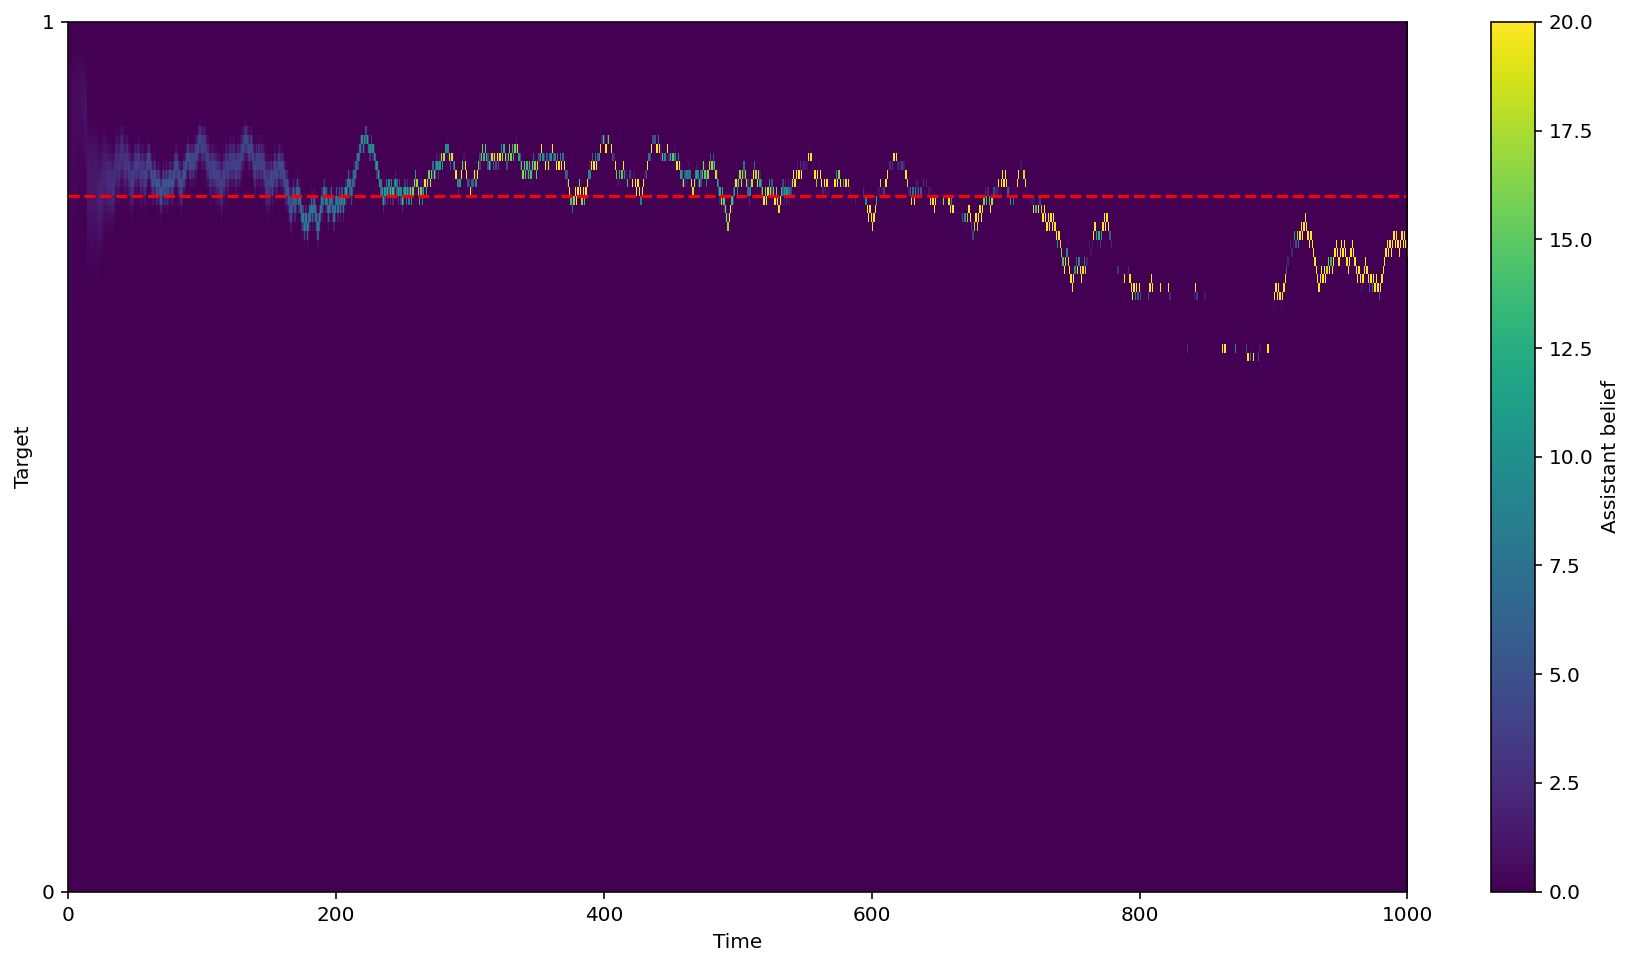

In [196]:
# Create figure
fig, ax = plt.subplots(figsize=(15, 8))
    
x = torch.linspace(0., 0.999, 100)

belief = []

for step in range(n_steps):
    mu, log_var = torch.from_numpy(belief_trace[step, :])
    std = torch.exp(0.5*log_var)
    x_scaled = torch.logit(x)
    belief_step = torch.distributions.Normal(mu, std).log_prob(x_scaled).exp().numpy()
    belief.append(belief_step)

x_min, x_max = 0, n_steps
y_min, y_max = 1.0, 0.0 # Note the inversion
im = ax.imshow(
    np.transpose(belief),
    extent = [x_min , x_max, y_min , y_max],
    interpolation="nearest",
    aspect="auto",
    cmap="viridis",
    vmin=0, vmax=20.0,
)

ax.axhline(user_goal, ls="--", color="red")

ax.invert_yaxis()
ax.yaxis.get_major_locator().set_params(integer=True)

ax.set_xlim((0, n_steps))

ax.set_xlabel("Time")
ax.set_ylabel("Target")

cb = fig.colorbar(im, ax=ax)
cb.set_label("Assistant belief")

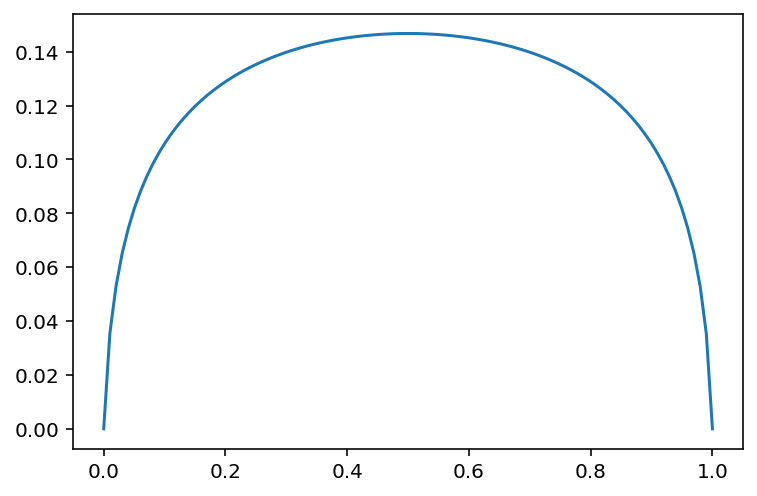

In [184]:
mu, log_var = torch.tensor([0.0, 2.0])
std = torch.exp(0.5*log_var)
x = torch.linspace(0.0, 1.0, 100)
x_scaled = torch.logit(x)
y = torch.distributions.Normal(mu, std).log_prob(x_scaled).exp().numpy()
x = x.numpy()

plt.plot(x, y)

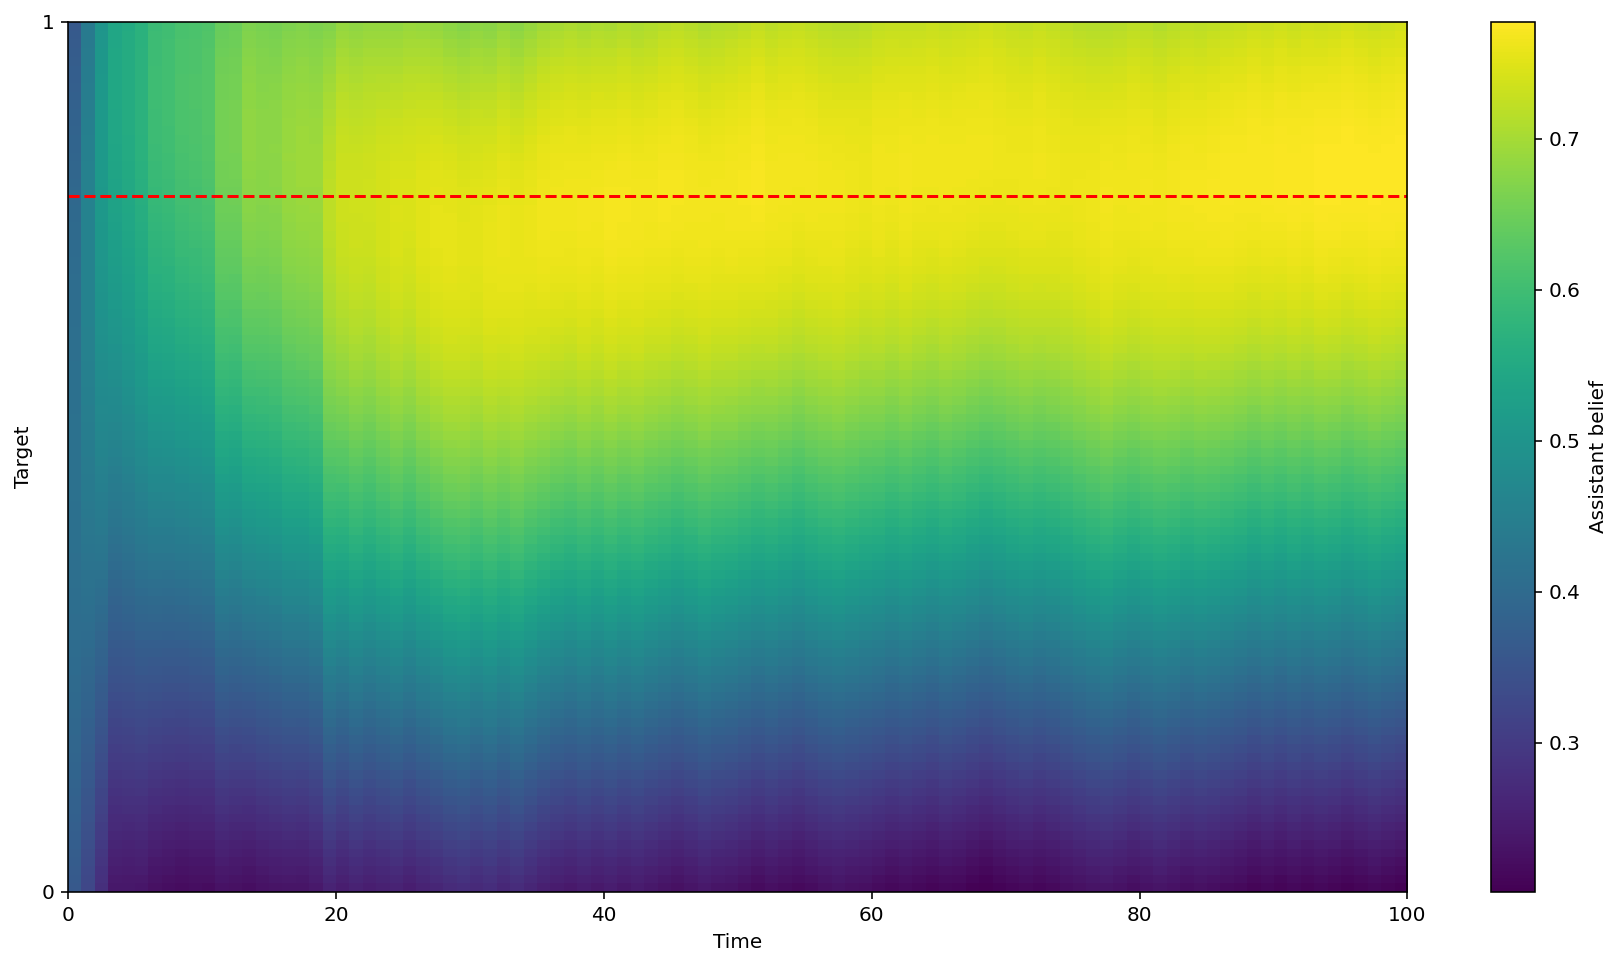

In [178]:
# Create figure
fig, ax = plt.subplots(figsize=(15, 8))
    
x = torch.linspace(0., 0.999, 100)

belief = []

for step in range(n_steps):
    mu, log_var = torch.from_numpy(belief_trace[step, :])
    std = torch.exp(0.5*log_var)
    belief_step = torch.distributions.Normal(torch.sigmoid(mu), torch.sigmoid(std)).log_prob(x).exp().numpy()
    belief.append(belief_step)

x_min, x_max = 0, n_steps
y_min, y_max = 1.0, 0.0 # Note the inversion
im = ax.imshow(
    np.transpose(belief),
    extent = [x_min , x_max, y_min , y_max],
    interpolation="nearest",
    aspect="auto",
    cmap="viridis",
    # vmin=0, vmax=1,
)

ax.axhline(user_goal, ls="--", color="red")

ax.invert_yaxis()
ax.yaxis.get_major_locator().set_params(integer=True)

ax.set_xlim((0, n_steps))

ax.set_xlabel("Time")
ax.set_ylabel("Target")

cb = fig.colorbar(im, ax=ax)
cb.set_label("Assistant belief")

In [156]:
max_epochs = 500
learning_rate = 0.01
n_sample = 10

b = torch.log(torch.tensor([3.0, 1.0]))
b_prime = torch.nn.Parameter(torch.zeros(2))

opt = torch.optim.Adam([b_prime, ], lr=learning_rate)

# b_prime_trace = []

# Minimise free energy
for epoch in tqdm(range(int(max_epochs))):

    # old_b_prime = b_prime.clone()

    opt.zero_grad()
    
    mu_b_prime, log_var_b_prime = b_prime
    std_b_prime = torch.exp(0.5*log_var_b_prime)
    
    eps = torch.randn(n_sample)
    # z = std_b_prime*eps + mu_b_prime
    
    dist_b_prime = torch.distributions.Normal(mu_b_prime, std_b_prime)
    z = dist_b_prime.sample((n_sample, ))

    log_q = dist_b_prime.log_prob(z).sum()
    
    mu_b, log_var_b = b
    std_b = torch.exp(0.5*log_var_b)
    dist_b = torch.distributions.Normal(mu_b, std_b)
    # dist_b = torch.distributions.Beta(*b.exp())
    log_p = dist_b.log_prob(z).sum()

    kl_est = log_q - log_p
    
    loss = kl_est
    loss.backward()
    opt.step()

#     if torch.isclose(old_b_prime, b_prime).all():
#         print(f"Converged at epoch {epoch}")
#         break
        
    # b_prime_trace.append(b_prime.detach().numpy().copy())

b, b_prime

100%|██████████| 500/500 [00:00<00:00, 674.81it/s]


(tensor([1.0986, 0.0000]),
 Parameter containing:
 tensor([ 0.0785, -0.0534], requires_grad=True))

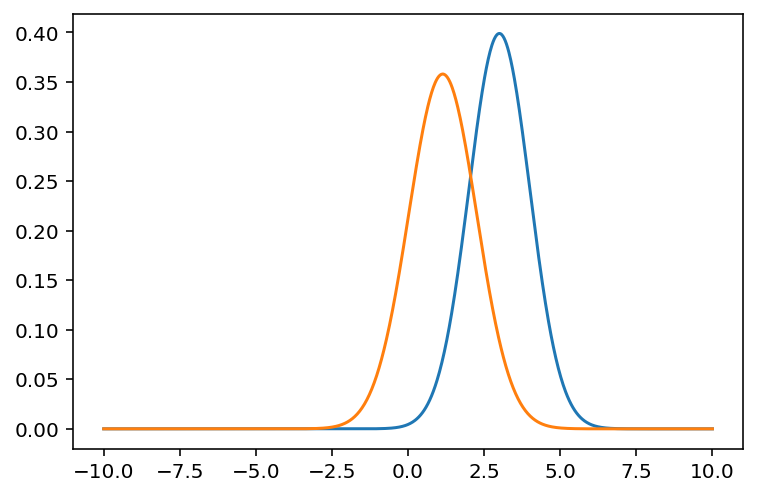

In [155]:
x = torch.linspace(-10., 10., 1000)
y1 = torch.distributions.Normal(*b.detach().exp()).log_prob(x).exp()
y2 = torch.distributions.Normal(*b_prime.detach().exp()).log_prob(x).exp()
plt.plot(x.numpy(), y1.numpy())
plt.plot(x.numpy(), y2.numpy())

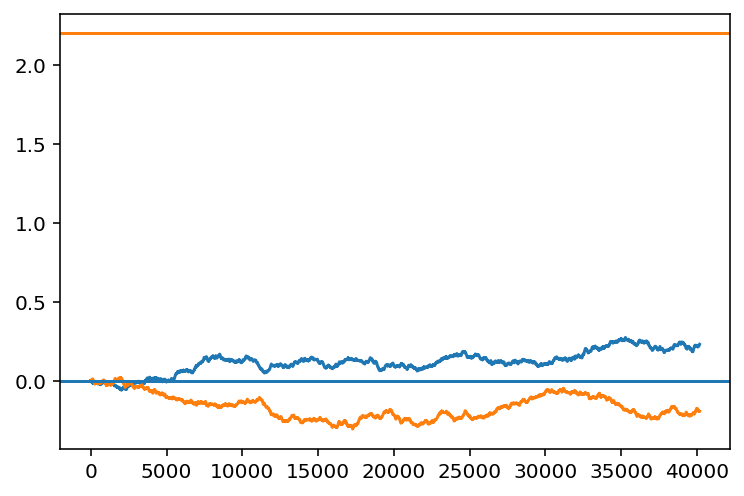

In [113]:
plt.plot(b_prime_trace)
plt.axhline(b.numpy()[0], color="C0")
plt.axhline(b.numpy()[1], color="C1")

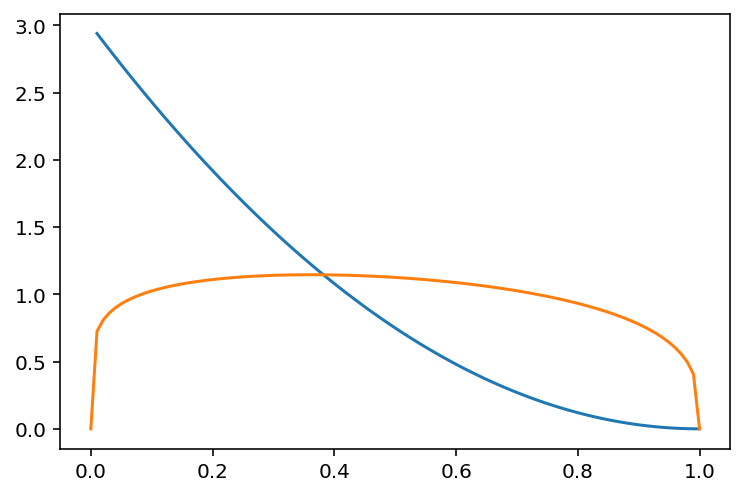

In [97]:
x = torch.linspace(0., 1., 100)
y1 = torch.distributions.Beta(*b.detach().exp()).log_prob(x).exp()
y2 = torch.distributions.Beta(*b_prime.detach().exp()).log_prob(x).exp()
plt.plot(x.numpy(), y1.numpy())
plt.plot(x.numpy(), y2.numpy())

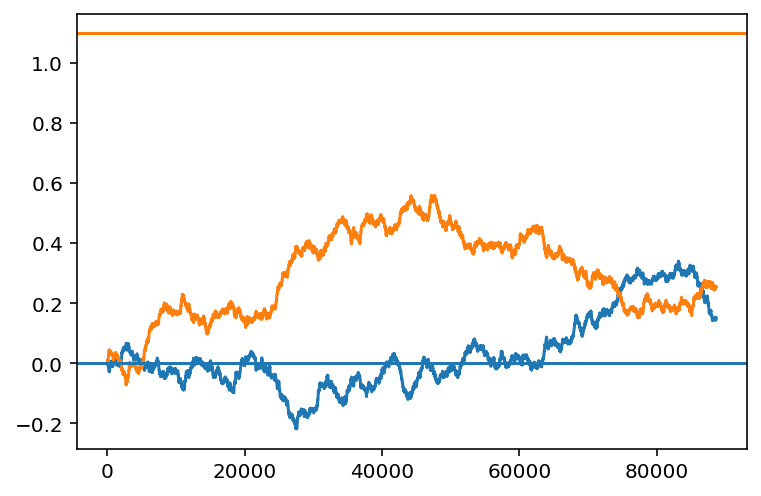

In [98]:
plt.plot(b_prime_trace)
plt.axhline(b.numpy()[0], color="C0")
plt.axhline(b.numpy()[1], color="C1")

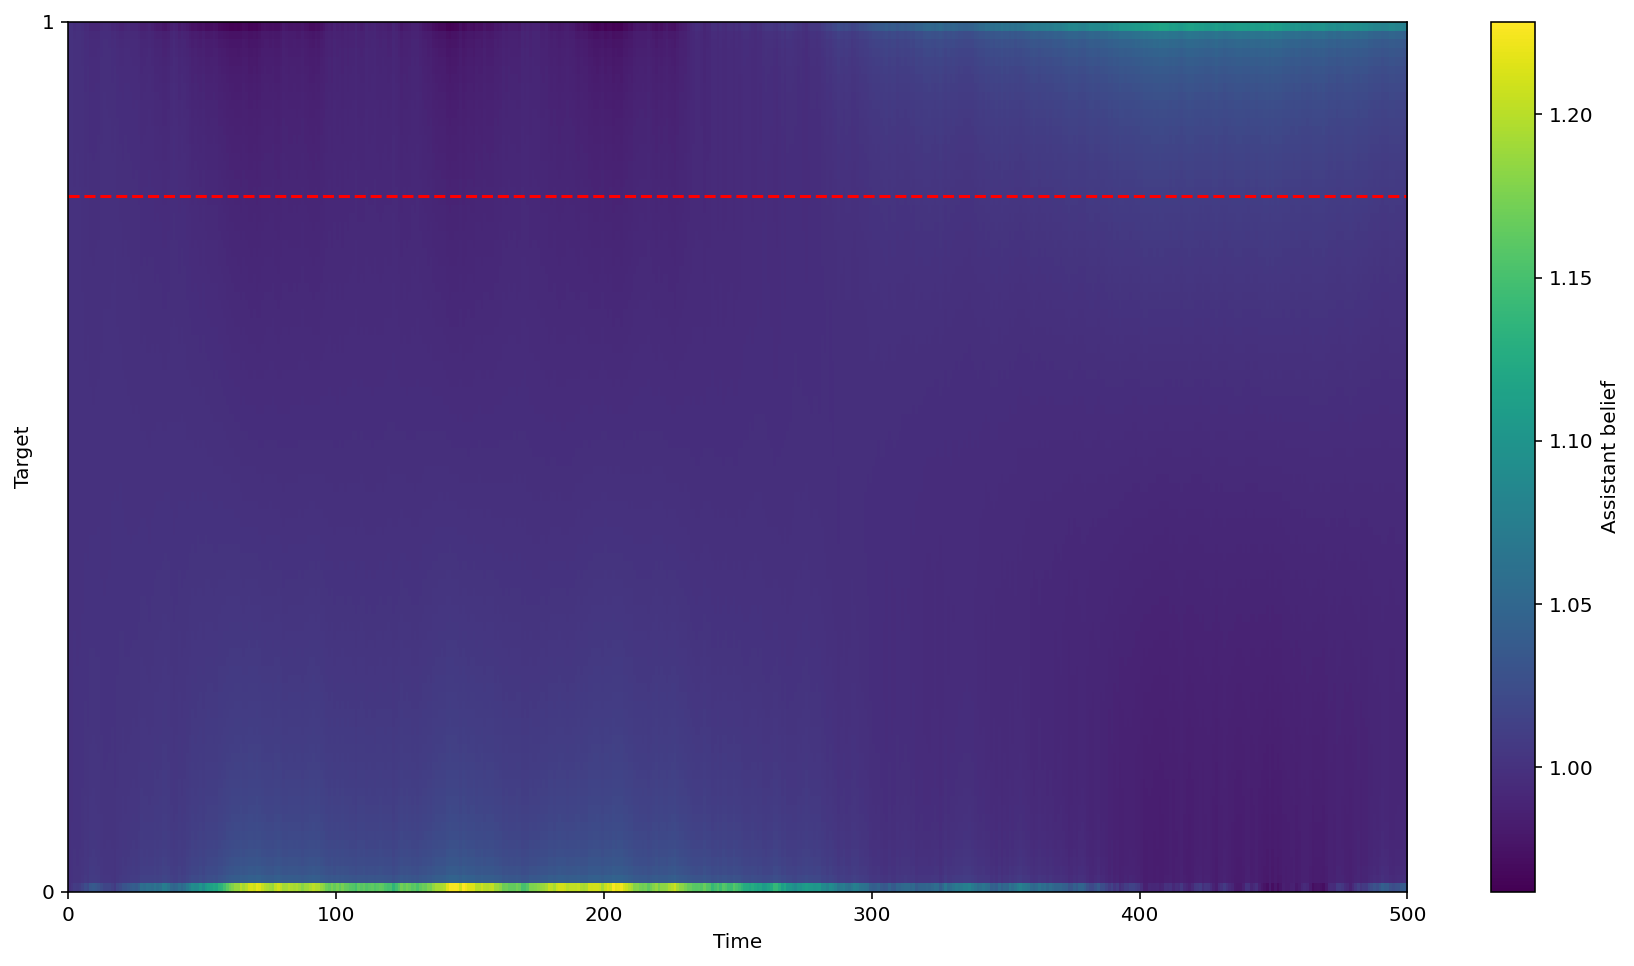

In [36]:
# Create figure
fig, ax = plt.subplots(figsize=(15, 8))
    
x = torch.linspace(0., 0.999, 100)

belief = []

for step in range(n_steps):
    log_c0, log_c1 = belief_trace[step, :]
    c0, c1 = np.exp(log_c0), np.exp(log_c1)
    belief_step = torch.distributions.Beta(concentration0=c0, concentration1=c1).log_prob(x+1e-08).exp().numpy()
    belief.append(belief_step)

x_min, x_max = 0, n_steps
y_min, y_max = 1.0, 0.0 # Note the inversion
im = ax.imshow(
    np.transpose(belief),
    extent = [x_min , x_max, y_min , y_max],
    interpolation="nearest",
    aspect="auto",
    cmap="viridis",
    # vmin=0, vmax=1,
)

ax.axhline(user_goal, ls="--", color="red")

ax.invert_yaxis()
ax.yaxis.get_major_locator().set_params(integer=True)

ax.set_xlim((0, n_steps))

ax.set_xlabel("Time")
ax.set_ylabel("Target")

cb = fig.colorbar(im, ax=ax)
cb.set_label("Assistant belief")

In [12]:
belief[-1]

array([0.97742337, 0.995801  , 0.9967252 , 0.99726343, 0.9976434 ,
       0.9979367 , 0.9981751 , 0.99837554, 0.9985482 , 0.99869967,
       0.99883425, 0.9989553 , 0.9990651 , 0.9991654 , 0.9992577 ,
       0.999343  , 0.9994222 , 0.99949604, 0.9995651 , 0.99963   ,
       0.99969095, 0.9997485 , 0.9998029 , 0.9998543 , 0.99990314,
       0.9999495 , 0.99999356, 1.0000355 , 1.0000756 , 1.0001137 ,
       1.0001501 , 1.0001849 , 1.0002182 , 1.0002499 , 1.0002803 ,
       1.0003093 , 1.0003371 , 1.0003638 , 1.0003892 , 1.0004135 ,
       1.0004369 , 1.0004592 , 1.0004804 , 1.0005007 , 1.0005201 ,
       1.0005386 , 1.0005561 , 1.0005728 , 1.0005887 , 1.0006037 ,
       1.0006179 , 1.0006313 , 1.0006438 , 1.0006558 , 1.0006667 ,
       1.000677  , 1.0006864 , 1.0006951 , 1.0007031 , 1.0007101 ,
       1.0007164 , 1.000722  , 1.0007267 , 1.0007306 , 1.0007337 ,
       1.000736  , 1.0007373 , 1.0007377 , 1.0007372 , 1.0007358 ,
       1.0007334 , 1.0007298 , 1.0007253 , 1.0007195 , 1.00071

In [64]:
torch.distributions.Beta(concentration0=1, concentration1=1).log_prob(torch.tensor([0.99, ])).exp()

tensor([1.])

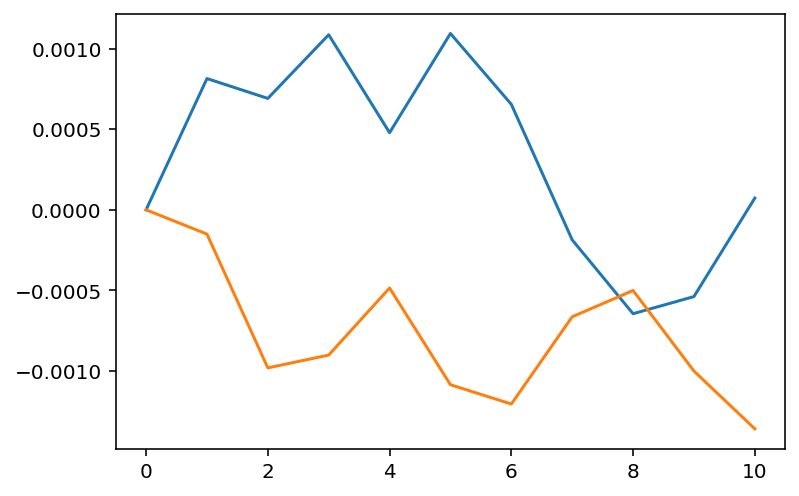

In [67]:
plt.plot(np.asarray(belief_trace));